# A4.4 Convolutional Neural Networks

*by Chuck Anderson for [CS545: Machine Learning](https://www.cs.colostate.edu/~anderson/cs545) at Colorado State University*

* 4.4: In sample runs, changed `conv_kernels` to `kernels_size_and_stride`
* 4.3: Moved the line that adds the Flatten module to the left one indentation level.
* 4.2: Corrected the code in Cell 11. A4grader.zip updated.
* 4.1: Lots of details added, including A4grader.zip

In this assignment, you will finish writing this new class, named `NeuralNetwork_Convolutional` that uses the `torch.nn` module to construct neural networks with initial convolutional layers followed by fully connected layers to learn to classify images.  Your main job is to finish the `train` function, following steps shown in lecture notes.

The network will have some number, possibly zero, layers of convolutional units having the `tanh` activation function.  These are followed by one or more layers with fully connected units with `tanh` activation functions.

A tricky part of building this structure is determining the correct number of inputs to the first fully-connected layer.  This requires knowing the size of the output image generated by the last convolutional layer.  If this layer produces an output image that is $n\times n$ and it has $m$ units, then the concatenation of all image values for all units into one vector to form the input to the fully-connected layer, the resulting vector will be $m \cdot n^2$.

As an example, say our data contains images that are $d\times d$ and we have a neural network with two convolutional layers and one fully connected layer. 

Original input image: 
- $d\times d$ of $c$ channels

First convolutional layer with $u_1$ units having kernels sized $k_1\times k_1$ and strides of $s_1$
- input is $d\times d$ of $c$ channels
- output is $z_1\times z_1$ of $u_1$ channels, where $z_1 = \frac{d - k_1}{s_1} + 1$

Second convolutional layer with $u_2$ units having kernels sized $k_2\times k_2$ and strides of $s_2$
- input is $z_1\times z_1$ of $u_1$ channels
- output is $z_2\times z_2$ of $u_2$ channels, where $z_2 = \frac{z_1 - k_2}{s_2} + 1$


Third convolutional layer is fully-connected, so we must flatten into a vector the output from the previous convolutional layer. Say this layer has $u_3$ units.
- input is $u_2 \, z_2 ^ 2$
- output is $u_3$ values

In [1]:
import numpy as np
import torch
import time
import copy
import sys

class NeuralNetwork_Convolutional():
    
    def __init__(self, n_channels_in_image, image_size,
                 n_units_in_conv_layers, kernels_size_and_stride,
                 n_units_in_fc_hidden_layers,
                 classes, use_gpu=False):

        if not isinstance(n_units_in_conv_layers, list):
            raise Exception('n_units_in_conv_layers must be a list')

        if not isinstance(n_units_in_fc_hidden_layers, list):
            raise Exception('n_units_in_fc_hidden_layers must be a list')
        
        if use_gpu and not torch.cuda.is_available():
            print('\nGPU is not available. Running on CPU.\n')
            use_gpu = False

        self.n_channels_in_image = n_channels_in_image
        self.image_size = image_size 
        self.n_units_in_conv_layers = n_units_in_conv_layers
        self.n_units_in_fc_hidden_layers = n_units_in_fc_hidden_layers
        self.kernels_size_and_stride = kernels_size_and_stride
        self.n_outputs = len(classes)
        self.classes = np.array(classes)
        self.use_gpu = use_gpu
        
        self.n_conv_layers = len(self.n_units_in_conv_layers)
        self.n_fc_hidden_layers = len(self.n_units_in_fc_hidden_layers)

        # Build the net layers
        self.nnet = torch.nn.Sequential()

        # Add convolutional layers

        n_units_previous = self.n_channels_in_image
        output_size_previous = self.image_size
        n_layers = 0
        if self.n_conv_layers > 0:

            for (n_units, kernel) in zip(self.n_units_in_conv_layers, self.kernels_size_and_stride):
                n_units_previous, output_size_previous = self._add_conv2d_tanh(n_layers,
                                        n_units_previous, output_size_previous, n_units, kernel)
                n_layers += 1 # for text label in layer
                
        # A4.3 version moved following statement left one indent level
        
        self.nnet.add_module('flatten', torch.nn.Flatten())  # prepare for fc layers

        n_inputs = output_size_previous ** 2 * n_units_previous
        if self.n_fc_hidden_layers > 0:
            for n_units in self.n_units_in_fc_hidden_layers:
                n_inputs = self._add_fc_tanh(n_layers, n_inputs, n_units)
                n_layers += 1

        self.nnet.add_module(f'output_{n_layers}', torch.nn.Linear(n_inputs, self.n_outputs))

        # Member variables for standardization
        self.Xmeans = None
        self.Xstds = None

        if self.use_gpu:
            self.nnet.cuda()

        self.n_epochs = 0
        self.error_trace = []

    def _add_conv2d_tanh(self, n_layers, n_units_previous, output_size_previous,
                   n_units, kernel_size_and_stride):
        kernel_size, kernel_stride = kernel_size_and_stride
        self.nnet.add_module(f'conv_{n_layers}', torch.nn.Conv2d(n_units_previous, n_units,
                                                                 kernel_size, kernel_stride))
        self.nnet.add_module(f'output_{n_layers}', torch.nn.Tanh())
        output_size_previous = (output_size_previous - kernel_size) // kernel_stride + 1
        n_units_previous = n_units                
        return n_units_previous, output_size_previous
    
    def _add_fc_tanh(self, n_layers, n_inputs, n_units):
        self.nnet.add_module(f'linear_{n_layers}', torch.nn.Linear(n_inputs, n_units))
        self.nnet.add_module(f'output_{n_layers}', torch.nn.Tanh())
        n_inputs = n_units
        return n_inputs

    def __repr__(self):
        str = f'''{type(self).__name__}(
                            n_channels_in_image={self.n_channels_in_image},
                            image_size={self.image_size},
                            n_units_in_conv_layers={self.n_units_in_conv_layers},
                            kernels_size_and_stride={self.kernels_size_and_stride},
                            n_units_in_fc_hidden_layers={self.n_units_in_fc_hidden_layers},
                            classes={self.classes},
                            use_gpu={self.use_gpu})'''

        str += self.nnet
        if self.n_epochs > 0:
            str += f'\n   Network was trained for {self.n_epochs} epochs that took {self.training_time:.4f} seconds.'
            str += f'\n   Final objective value is {self.error_trace[-1]:.3f}'
        else:
            str += '  Network is not trained.'
        return str
        
    def _standardizeX(self, X):
        result = (X - self.Xmeans) / self.XstdsFixed
        result[:, self.Xconstant] = 0.0
        return result

    def _unstandardizeX(self, Xs):
        return self.Xstds * Xs + self.Xmeans

    def _setup_standardize(self, X, T):
        if self.Xmeans is None:
            self.Xmeans = X.mean(axis=0)
            self.Xstds = X.std(axis=0)
            self.Xconstant = self.Xstds == 0
            self.XstdsFixed = copy.copy(self.Xstds)
            self.XstdsFixed[self.Xconstant] = 1

    def train(self, X, T, n_epochs, learning_rate=0.01):

        start_time = time.time()
        
        self.learning_rate = learning_rate

        if T.ndim == 1:
            T = T.reshape((-1, 1))

        _, T = np.where(T == self.classes)  # convert to labels from 0

        self._setup_standardize(X, T)
        X = self._standardizeX(X)

        X = torch.tensor(X)
    
        T = torch.tensor(T.reshape(-1))
        if self.use_gpu:
            X = X.cuda()
            T = T.cuda()

        loss_F = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.nnet.parameters(), lr=learning_rate)

        for epoch in range(n_epochs):
            optimizer.zero_grad()
        
            Y = self.nnet(X)
            error = loss_F(Y, T)
            self.error_trace.append(error)
            error.backward()
            optimizer.step()
            
        if epoch % 50 == 0:
            print(f'Epoch {epoch} error {error}')
        
        end_time = time.time()
        self.training_time = end_time - start_time
 
            
    def get_error_trace(self):
        return self.error_trace
    
    def _softmax(self, Y):
        mx = Y.max()
        expY = np.exp(Y - mx)
        denom = expY.sum(axis=1).reshape((-1, 1)) + sys.float_info.epsilon
        return expY / denom
    
    def use(self, X):
        self.nnet.eval()  # turn off gradients and other aspects of training
        X = self._standardizeX(X)
        X = torch.tensor(X)
        if self.use_gpu:
            X = X.cuda()

        Y = self.nnet(X)

        if self.use_gpu:
            Y = Y.cpu()
        Y = Y.detach().numpy()
        Yclasses = self.classes[Y.argmax(axis=1)].reshape((-1, 1))

        return Yclasses, self._softmax(Y)

In [2]:
import matplotlib.pyplot as plt

def show_layer_output(nnet, X_sample, layer):
    outputs = []
    reg = nnet.nnet[layer * 2].register_forward_hook(
        lambda self, i, o: outputs.append(o))
    nnet.use(X_sample)
    reg.remove()
    output = outputs[0]

    n_units = output.shape[1]
    nplots = int(np.sqrt(n_units)) + 1
    for unit in range(n_units):
        plt.subplot(nplots, nplots, unit+1)
        plt.imshow(output[0, unit, :, :].detach(),cmap='binary')
        plt.axis('off')
    return output

def show_layer_weights(nnet, layer):
    W = nnet.nnet[layer*2].weight.detach()
    n_units = W.shape[0]
    nplots = int(np.sqrt(n_units)) + 1
    for unit in range(n_units):
        plt.subplot(nplots, nplots, unit + 1)
        plt.imshow(W[unit, 0, :, :], cmap='binary')
        plt.axis('off')
    return W

## MNIST Digits

Investigate the application of your code to the classification of MNIST digits, which you may download from [this site](http://deeplearning.net/tutorial/gettingstarted.html).

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pickle, gzip

# Load the dataset
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
    
Xtrain = train_set[0]
Ttrain = train_set[1]
Xtest = test_set[0]
Ttest = test_set[1]
Xtrain = Xtrain.reshape(-1, 1, 28, 28)
Xtest = Xtest.reshape(-1, 1, 28, 28)
Ttest.reshape(-1)
a = Xtrain[0, :].reshape(28, 28)

Training  : 12646 out of 50000 (25.3%) samples classified correctly.
Testing   :  2615 out of 10000 (26.2%) samples classified correctly.


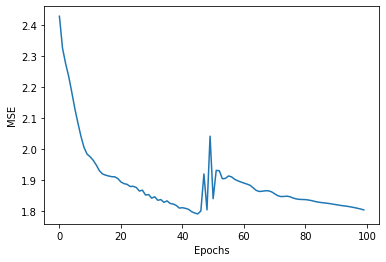

In [4]:
nnet = NeuralNetwork_Convolutional(n_channels_in_image=Xtrain.shape[1],
                                   image_size=Xtrain.shape[2],
                                   n_units_in_conv_layers=[2, 4],
                                   kernels_size_and_stride=[[3, 4]], 
                                   n_units_in_fc_hidden_layers=[1, 5],
                                   classes= np.unique(Ttrain),
                                   use_gpu=False)

nnet.train(Xtrain, Ttrain, 100, learning_rate=0.1)


for name, X, T in (('Training', Xtrain, Ttrain),
                   ('Testing', Xtest, Ttest)):
    Y, _ = nnet.use(X)
    T = T.reshape((-1, 1))
    nc = np.sum(T == Y)
    Tshape = T.shape[0]
    print(f'{name:10}: {nc:5d} out of {Tshape:5d} ({nc / Tshape * 100:.1f}%) samples classified correctly.')
    
plt.plot(nnet.get_error_trace())
plt.xlabel('Epochs')
plt.ylabel('MSE');

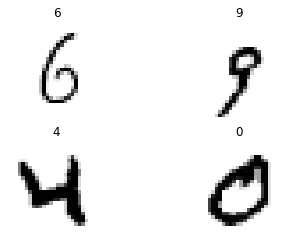

In [5]:
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.imshow(Xtrain[i+18, :].reshape(28, 28), cmap='binary')
    plt.title(Ttrain[i+18])
    plt.axis('off');
    


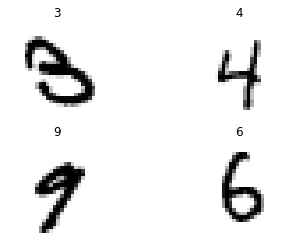

In [6]:
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.imshow(Xtest[i+18, :].reshape(28, 28), cmap='binary')
    plt.title(Ttest[i+18])
    plt.axis('off');

# Changing the number of units in the convolution layers 

Training  : 10551 out of 50000 (21.1%) samples classified correctly.
Testing   :  2092 out of 10000 (20.9%) samples classified correctly.


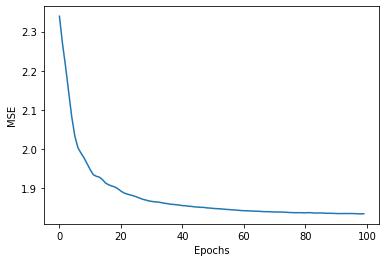

In [7]:
nnet = NeuralNetwork_Convolutional(n_channels_in_image=Xtrain.shape[1],
                                   image_size=Xtrain.shape[2],
                                   n_units_in_conv_layers=[],
                                   kernels_size_and_stride=[[3, 4]], 
                                   n_units_in_fc_hidden_layers=[1, 5],
                                   classes= np.unique(Ttrain),
                                   use_gpu=False)

nnet.train(Xtrain, Ttrain, 100, learning_rate=0.1)


for name, X, T in (('Training', Xtrain, Ttrain),
                   ('Testing', Xtest, Ttest)):
    Y, _ = nnet.use(X)
    T = T.reshape((-1, 1))
    nc = np.sum(T == Y)
    Tshape = T.shape[0]
    print(f'{name:10}: {nc:5d} out of {Tshape:5d} ({nc / Tshape * 100:.1f}%) samples classified correctly.')
    
plt.plot(nnet.get_error_trace())
plt.xlabel('Epochs')
plt.ylabel('MSE');

Training  : 16830 out of 50000 (33.7%) samples classified correctly.
Testing   :  3369 out of 10000 (33.7%) samples classified correctly.


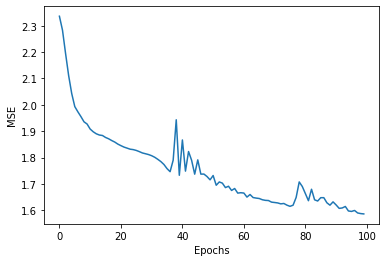

In [8]:
nnet = NeuralNetwork_Convolutional(n_channels_in_image=Xtrain.shape[1],
                                   image_size=Xtrain.shape[2],
                                   n_units_in_conv_layers=[2, 5],
                                   kernels_size_and_stride=[[3, 4]], 
                                   n_units_in_fc_hidden_layers=[1, 5],
                                   classes= np.unique(Ttrain),
                                   use_gpu=False)

nnet.train(Xtrain, Ttrain, 100, learning_rate=0.1)


for name, X, T in (('Training', Xtrain, Ttrain),
                   ('Testing', Xtest, Ttest)):
    Y, _ = nnet.use(X)
    T = T.reshape((-1, 1))
    nc = np.sum(T == Y)
    Tshape = T.shape[0]
    print(f'{name:10}: {nc:5d} out of {Tshape:5d} ({nc / Tshape * 100:.1f}%) samples classified correctly.')
    
plt.plot(nnet.get_error_trace())
plt.xlabel('Epochs')
plt.ylabel('MSE');

### Observations:
Increasing the number of units in the convolution layers increases the accuracy of the samples that are classified correctly. When tried to increase the number of units to approximately to 10, 12, the accuracy of correctly classifying the samples,is above 90%. However, decreasing the number of units in the convolution error, decreases the accuracy dramatically.

# Changing the number of hidden layers


Training  : 44901 out of 50000 (89.8%) samples classified correctly.
Testing   :  9044 out of 10000 (90.4%) samples classified correctly.


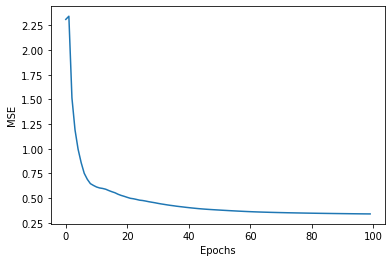

In [9]:
nnet = NeuralNetwork_Convolutional(n_channels_in_image=Xtrain.shape[1],
                                   image_size=Xtrain.shape[2],
                                   n_units_in_conv_layers=[2, 4],
                                   kernels_size_and_stride=[[3, 4]], 
                                   n_units_in_fc_hidden_layers=[],
                                   classes= np.unique(Ttrain),
                                   use_gpu=False)

nnet.train(Xtrain, Ttrain, 100, learning_rate=0.1)


for name, X, T in (('Training', Xtrain, Ttrain),
                   ('Testing', Xtest, Ttest)):
    Y, _ = nnet.use(X)
    T = T.reshape((-1, 1))
    nc = np.sum(T == Y)
    Tshape = T.shape[0]
    print(f'{name:10}: {nc:5d} out of {Tshape:5d} ({nc / Tshape * 100:.1f}%) samples classified correctly.')
    
plt.plot(nnet.get_error_trace())
plt.xlabel('Epochs')
plt.ylabel('MSE');

Training  : 40772 out of 50000 (81.5%) samples classified correctly.
Testing   :  8259 out of 10000 (82.6%) samples classified correctly.


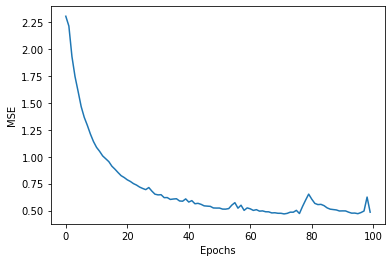

In [10]:
nnet = NeuralNetwork_Convolutional(n_channels_in_image=Xtrain.shape[1],
                                   image_size=Xtrain.shape[2],
                                   n_units_in_conv_layers=[2, 4],
                                   kernels_size_and_stride=[[3, 4]], 
                                   n_units_in_fc_hidden_layers=[5, 8],
                                   classes= np.unique(Ttrain),
                                   use_gpu=False)

nnet.train(Xtrain, Ttrain, 100, learning_rate=0.1)


for name, X, T in (('Training', Xtrain, Ttrain),
                   ('Testing', Xtest, Ttest)):
    Y, _ = nnet.use(X)
    T = T.reshape((-1, 1))
    nc = np.sum(T == Y)
    Tshape = T.shape[0]
    print(f'{name:10}: {nc:5d} out of {Tshape:5d} ({nc / Tshape * 100:.1f}%) samples classified correctly.')
    
plt.plot(nnet.get_error_trace())
plt.xlabel('Epochs')
plt.ylabel('MSE');

### Observations: 
Changing the number of hidden layers doesn't have much effect on accuracy, as increasing the number of hidden layers gives approximately the same percentage of correctly classified samples.

# Changing the kernels_size and strides

Training  : 16115 out of 50000 (32.2%) samples classified correctly.
Testing   :  3143 out of 10000 (31.4%) samples classified correctly.


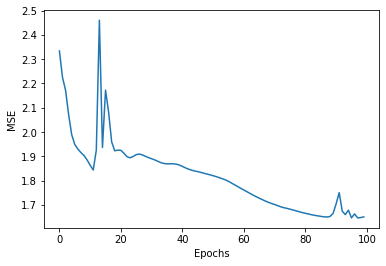

In [13]:
nnet = NeuralNetwork_Convolutional(n_channels_in_image=Xtrain.shape[1],
                                   image_size=Xtrain.shape[2],
                                   n_units_in_conv_layers=[2, 4],
                                   kernels_size_and_stride=[[1, 3]], 
                                   n_units_in_fc_hidden_layers=[1, 5],
                                   classes= np.unique(Ttrain),
                                   use_gpu=False)

nnet.train(Xtrain, Ttrain, 100, learning_rate=0.1)


for name, X, T in (('Training', Xtrain, Ttrain),
                   ('Testing', Xtest, Ttest)):
    Y, _ = nnet.use(X)
    T = T.reshape((-1, 1))
    nc = np.sum(T == Y)
    Tshape = T.shape[0]
    print(f'{name:10}: {nc:5d} out of {Tshape:5d} ({nc / Tshape * 100:.1f}%) samples classified correctly.')
    
plt.plot(nnet.get_error_trace())
plt.xlabel('Epochs')
plt.ylabel('MSE');

Training  : 18768 out of 50000 (37.5%) samples classified correctly.
Testing   :  3727 out of 10000 (37.3%) samples classified correctly.


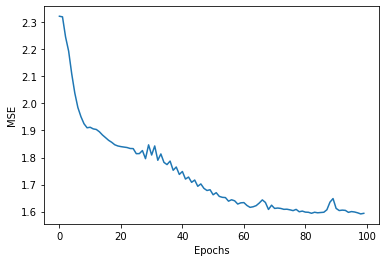

In [14]:
nnet = NeuralNetwork_Convolutional(n_channels_in_image=Xtrain.shape[1],
                                   image_size=Xtrain.shape[2],
                                   n_units_in_conv_layers=[2, 4],
                                   kernels_size_and_stride=[[3, 5]], 
                                   n_units_in_fc_hidden_layers=[1, 5],
                                   classes= np.unique(Ttrain),
                                   use_gpu=False)

nnet.train(Xtrain, Ttrain, 100, learning_rate=0.1)


for name, X, T in (('Training', Xtrain, Ttrain),
                   ('Testing', Xtest, Ttest)):
    Y, _ = nnet.use(X)
    T = T.reshape((-1, 1))
    nc = np.sum(T == Y)
    Tshape = T.shape[0]
    print(f'{name:10}: {nc:5d} out of {Tshape:5d} ({nc / Tshape * 100:.1f}%) samples classified correctly.')
    
plt.plot(nnet.get_error_trace())
plt.xlabel('Epochs')
plt.ylabel('MSE');

### Observations:
Changing the kernel size and strides affects the accuracy of correctly classifying the samples, increasing both the size and the stride, causes the accuracy to increase. in this case, very slightly, however when tried for larger values the accuracy of correctly classifying the samples is above 90%.

# Changing the learning rates 

Training  : 11109 out of 50000 (22.2%) samples classified correctly.
Testing   :  2206 out of 10000 (22.1%) samples classified correctly.


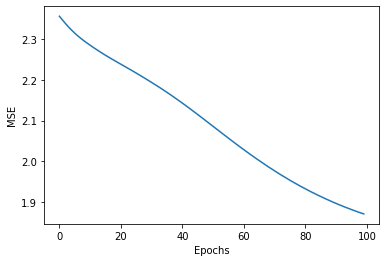

In [15]:
nnet = NeuralNetwork_Convolutional(n_channels_in_image=Xtrain.shape[1],
                                   image_size=Xtrain.shape[2],
                                   n_units_in_conv_layers=[2, 4],
                                   kernels_size_and_stride=[[3, 4]], 
                                   n_units_in_fc_hidden_layers=[1, 5],
                                   classes= np.unique(Ttrain),
                                   use_gpu=False)

nnet.train(Xtrain, Ttrain, 100, learning_rate=0.005)


for name, X, T in (('Training', Xtrain, Ttrain),
                   ('Testing', Xtest, Ttest)):
    Y, _ = nnet.use(X)
    T = T.reshape((-1, 1))
    nc = np.sum(T == Y)
    Tshape = T.shape[0]
    print(f'{name:10}: {nc:5d} out of {Tshape:5d} ({nc / Tshape * 100:.1f}%) samples classified correctly.')
    
plt.plot(nnet.get_error_trace())
plt.xlabel('Epochs')
plt.ylabel('MSE');

Training  : 13908 out of 50000 (27.8%) samples classified correctly.
Testing   :  2781 out of 10000 (27.8%) samples classified correctly.


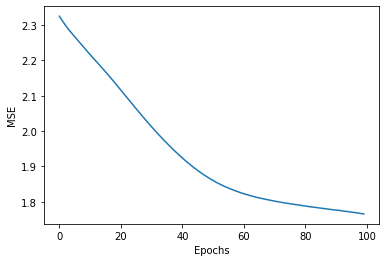

In [16]:
nnet = NeuralNetwork_Convolutional(n_channels_in_image=Xtrain.shape[1],
                                   image_size=Xtrain.shape[2],
                                   n_units_in_conv_layers=[2, 4],
                                   kernels_size_and_stride=[[3, 4]], 
                                   n_units_in_fc_hidden_layers=[1, 5],
                                   classes= np.unique(Ttrain),
                                   use_gpu=False)

nnet.train(Xtrain, Ttrain, 100, learning_rate=0.01)


for name, X, T in (('Training', Xtrain, Ttrain),
                   ('Testing', Xtest, Ttest)):
    Y, _ = nnet.use(X)
    T = T.reshape((-1, 1))
    nc = np.sum(T == Y)
    Tshape = T.shape[0]
    print(f'{name:10}: {nc:5d} out of {Tshape:5d} ({nc / Tshape * 100:.1f}%) samples classified correctly.')
    
plt.plot(nnet.get_error_trace())
plt.xlabel('Epochs')
plt.ylabel('MSE');

### Observations:
Increasing the learning rate increases the accuracy of samples that are correctly classified. Setting the learning rate to 0, gives an accuracy of 10%, however increasing the learning rate to 0.005 and 0.01, gives an accuracy of about 22%

# Changing the number of epochs


Training  : 10701 out of 50000 (21.4%) samples classified correctly.
Testing   :  2138 out of 10000 (21.4%) samples classified correctly.


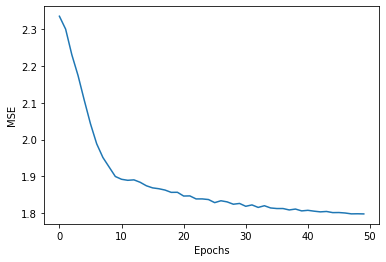

In [17]:
nnet = NeuralNetwork_Convolutional(n_channels_in_image=Xtrain.shape[1],
                                   image_size=Xtrain.shape[2],
                                   n_units_in_conv_layers=[2, 4],
                                   kernels_size_and_stride=[[3, 4]], 
                                   n_units_in_fc_hidden_layers=[1, 5],
                                   classes= np.unique(Ttrain),
                                   use_gpu=False)

nnet.train(Xtrain, Ttrain, 50, learning_rate=0.1)


for name, X, T in (('Training', Xtrain, Ttrain),
                   ('Testing', Xtest, Ttest)):
    Y, _ = nnet.use(X)
    T = T.reshape((-1, 1))
    nc = np.sum(T == Y)
    Tshape = T.shape[0]
    print(f'{name:10}: {nc:5d} out of {Tshape:5d} ({nc / Tshape * 100:.1f}%) samples classified correctly.')
    
plt.plot(nnet.get_error_trace())
plt.xlabel('Epochs')
plt.ylabel('MSE');

Training  : 11731 out of 50000 (23.5%) samples classified correctly.
Testing   :  2399 out of 10000 (24.0%) samples classified correctly.


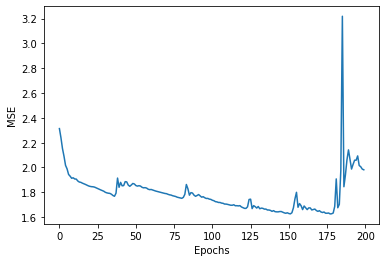

In [18]:
nnet = NeuralNetwork_Convolutional(n_channels_in_image=Xtrain.shape[1],
                                   image_size=Xtrain.shape[2],
                                   n_units_in_conv_layers=[2, 4],
                                   kernels_size_and_stride=[[3, 4]], 
                                   n_units_in_fc_hidden_layers=[1, 5],
                                   classes= np.unique(Ttrain),
                                   use_gpu=False)

nnet.train(Xtrain, Ttrain, 200, learning_rate=0.1)


for name, X, T in (('Training', Xtrain, Ttrain),
                   ('Testing', Xtest, Ttest)):
    Y, _ = nnet.use(X)
    T = T.reshape((-1, 1))
    nc = np.sum(T == Y)
    Tshape = T.shape[0]
    print(f'{name:10}: {nc:5d} out of {Tshape:5d} ({nc / Tshape * 100:.1f}%) samples classified correctly.')
    
plt.plot(nnet.get_error_trace())
plt.xlabel('Epochs')
plt.ylabel('MSE');

### Observations:
Increasing the number of epochs increases the accuracy of the correctly classified samples.

The reason, for keeping smaller values for all the attributes, is that my machine gives me an OS error, for not allocating enough memory. However I have tried running the code for larger values, hence the observations.

# Grading

Download [A4grader.zip](https://www.cs.colostate.edu/~anderson/cs545/notebooks/A4grader.zip) and extract A4grader.py from it. 

In [19]:
%run -i A4grader.py


======================= Code Execution =======================

Extracting python code from notebook named 'Gowaikar-A4.ipynb' and storing in notebookcode.py
Removing all statements that are not function or class defs or import statements.

Testing if your NeuralNetwork_Convolutional can learn to classify a small 
subset of hand_drawn 0, 1, and 2 digits.

import numpy as np
import pickle, gzip

# Load the dataset
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
Xtest = test_set[0]
traini = [3,  10,  13,  25,  28,  55,  69,  71, 101, 126, 2,   5,  14,  29,  31,  37,  39,  40,  46,  57, 1,  35,  38,  43,  47,  72,  77,  82, 106, 119]
testi = [136, 148, 157, 183, 188, 192, 194, 215, 246, 269,  74,  89,  94, 96, 107, 135, 137, 143, 145, 154, 147, 149, 172, 174, 186, 199, 208, 221, 222, 225]
Xtrain = test_set[0][traini, :].reshape(-1, 1, 28, 28)
Ttrain = test_set[1][traini].reshape(-1, 1)
Xtest = test_set[0][testi, :].reshape

# Extra Credit

1. For one of your runs, display the output images of your convolutional layers 
   and the weights for those layers.  Discuss what you see.  Describe why the
   displayed weight patterns result in the output images of the first convolutional
   layer.
2. Make at least one of your runs on a workstation with a GPU and run with use_gpu=True.
   Also run it with use_gpu=False.  Discuss the differences in training times.